In [1]:
import numpy as np
import math
from collections import defaultdict
import random
import re
import matplotlib.pyplot as plt

#functions

#extract sequences that satisfy various constraints, write them to output files
#filename - input file in the format copies-sequence
#klen - length of the motif to extract for inspection
#copies - threshold number of sequence copies
#position - position in the sequence from where to extract the motif
#singletduplet - criterion for sequence extraction - single or double GGA
#foreback - type of extraction - foreground/background (then copies is used as lower/upper bound)
#outname - name of output file
def getSeq(filename, klen, copies, position, singletduplet, foreback, outname):
    outFile = open(outname, "w")
    p = re.compile('\s+(\d+)\s+(\S+)')
    with open(filename) as infile:
        line = infile.readline()
        while(line):
            m = p.match(line)
            if(m):
                (seq, count) = (str(m.group(2)), int(m.group(1)))
                if (foreback == 'F'):
                    if(count >= copies):
                        motif = seq[position:position+klen]
                        if(singletduplet == 'D'):
                            if(motif in ('GGACGGA', 'GGAAGGA', 'GGAGGGA', 'GGATGGA')):
                               outFile.write(seq + "\n")
                        elif(singletduplet == 'S'):
                            if(motif[-3:] == 'GGA' and not(re.search(r'GGA', motif[:-3]))):
                                outFile.write(seq + "\n")
                elif (foreback == 'B'):
                    if(count <= copies):
                        motif = seq[position:position+klen]
                        if(singletduplet == 'D'):
                            if(motif in ('GGACGGA', 'GGAAGGA', 'GGAGGGA', 'GGATGGA')):
                               outFile.write(seq + "\n")
                        elif(singletduplet == 'S'):
                            if(motif[-3:] == 'GGA' and not(re.search(r'GGA', motif[:-3]))):
                                outFile.write(seq + "\n")
            line = infile.readline()
    outFile.close()
    
#function that calculates position-based nucleotide frequencies at each position within a range
def freq_from_input(fileName, start, RNAlen):
    counts = {i:{} for i in range(RNAlen)}
    
    with open(fileName) as f:
        for line in f:
            line.rstrip()
            line = line[start:start+RNAlen]
            for i in range(RNAlen):
                if(not line[i] in counts[i]):
                    counts[i][line[i]] = 1
                else:
                    counts[i][line[i]] += 1

    for i in range(RNAlen):
        total = sum(counts[i].values())
        for j in counts[i].keys():
            counts[i][j] /= total
    
    return counts

#function that calculates position-wise relative entropy
#and also identifies the nucleotide with the largest difference
def relative_entropy(fore, back, seqLen):
    positionalEntropy = {}
    letters = []
    for i in range(seqLen):
        positionalEntropy[i+1] = 0
        max = 0
        letter = None
        for key in fore[i].keys():
            val = fore[i][key] * np.log(fore[i][key]/back[i][key])
            positionalEntropy[i+1] += val
            if(val > max):
                max = val
                letter = key
        letters.append(letter)
    return (letters, positionalEntropy)


In [2]:
#input files
backFile = "/Users/zavolan/Collaborations/AllainGroup/BSSE_QGF_35614_150820_D00535_0100_AC7P8HANXX_6_ATCACG_L006_R1_001_Selex_S0_1.counted"
foreFile = "/Users/zavolan/Collaborations/AllainGroup/BSSE_QGF_35620_150820_D00535_0100_AC7P8HANXX_6_CAGATC_L006_R1_001_Selex_S6_7.counted"
singleForeFile = "/Users/zavolan/Collaborations/AllainGroup/GGAfg.seq"
singleBackFile = "/Users/zavolan/Collaborations/AllainGroup/GGAbg.seq"
doubleForeFile = "/Users/zavolan/Collaborations/AllainGroup/GGANGGAfg.seq"
doubleBackFile = "/Users/zavolan/Collaborations/AllainGroup/GGANGGAbg.seq"
singleRelEntropy = "/Users/zavolan/Collaborations/AllainGroup/relativeEntropyGGA.png"
doubleRelEntropy = "/Users/zavolan/Collaborations/AllainGroup/relativeEntropyGGANGGA.png"
#parameters
motiflen = 7
foregroundThreshold = 100
backgroundThreshold = 10
wmStart = 20
motifStart = 28
seqLen = 27

#extract foreground/background sequences
getSeq(foreFile, motiflen, foregroundThreshold, motifStart, 'D', 'F', doubleForeFile)
getSeq(foreFile, motiflen, foregroundThreshold, motifStart, 'S', 'F', singleForeFile)
getSeq(backFile, motiflen, backgroundThreshold, motifStart, 'D', 'B', doubleBackFile)
getSeq(backFile, motiflen, backgroundThreshold, motifStart, 'S', 'B', singleBackFile)

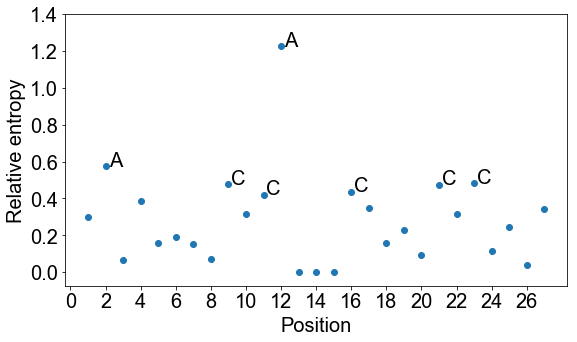

In [9]:
#apply the functions and get the data based on the input files
#first single GGA case
positiveFreqs = freq_from_input(singleForeFile, wmStart, seqLen)
negativeFreqs = freq_from_input(singleBackFile, wmStart, seqLen)
(letters, relativeEntropy) = relative_entropy(positiveFreqs, negativeFreqs, seqLen)

#generate the plot
plt.figure(figsize=(9,5))
(xs, ys) = ([int(x) for x in relativeEntropy.keys()], relativeEntropy.values())
plt.scatter(xs,ys)
plt.xticks(np.arange(0, seqLen, step=2), fontsize=20, fontname='Arial')
plt.yticks(np.arange(0, 1.5, step=0.2), fontsize=20, fontname='Arial')

#label the points that are outliers
for x,y in zip(xs,ys):
    # letters is an array starting at index 0, not 1
    label = None
    if(y > 0.4):
        label = letters[x-1]
    else:
        label = ""
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,0), # distance from text to points (x,y)
                 ha='center', fontsize=20, fontname='Arial') # horizontal alignment can be left, right or center
plt.xlabel("Position",fontsize=20, fontname='Arial')
plt.ylabel("Relative entropy",fontsize=20, fontname='Arial')

#save the figure
plt.savefig(singleRelEntropy, dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1)

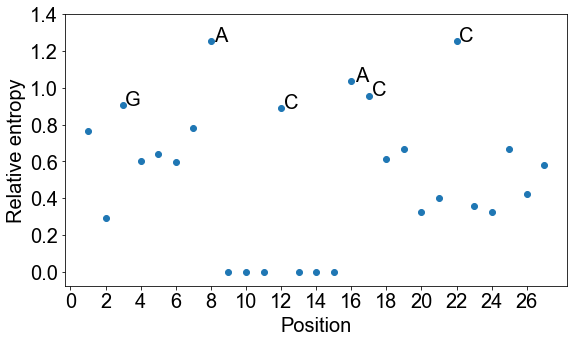

In [6]:
#apply the functions and get the data based on the input files
#first single GGA case
positiveFreqs = freq_from_input(doubleForeFile, wmStart, seqLen)
negativeFreqs = freq_from_input(doubleBackFile, wmStart, seqLen)
(letters, relativeEntropy) = relative_entropy(positiveFreqs, negativeFreqs, seqLen)

#generate the plot
plt.figure(figsize=(9,5))
(xs, ys) = ([int(x) for x in relativeEntropy.keys()], relativeEntropy.values())
plt.scatter(xs,ys)
plt.xticks(np.arange(0, seqLen, step=2), fontsize=20, fontname='Arial')
plt.yticks(np.arange(0, 1.5, step=0.2), fontsize=20, fontname='Arial')

#label the points that are outliers
for x,y in zip(xs,ys):
    # letters is an array starting at index 0, not 1
    label = None
    if(y > 0.8):
        label = letters[x-1]
    else:
        label = ""
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,0), # distance from text to points (x,y)
                 ha='center', fontsize=20, fontname='Arial') # horizontal alignment can be left, right or center
plt.xlabel("Position",fontsize=20, fontname='Arial')
plt.ylabel("Relative entropy",fontsize=20, fontname='Arial')

#save the figure
plt.savefig(doubleRelEntropy, dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1)